**Importation de modele**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge,LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from skforecast.preprocessing import RollingFeatures
from sklearn.preprocessing import StandardScaler
from skforecast.direct import ForecasterDirect
from skforecast.recursive import ForecasterRecursive
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb
from skforecast.plot import set_dark_theme


**Les constante**

In [2]:
TEST_SIZE = 24
LAG_SIZE = 6
WINDOW_SIZE = 4

In [20]:
# Charger les données
data = pd.read_csv("../../data/raw/mouvements_stock_fictifs.csv", delimiter=',', header=0, parse_dates=True, index_col=0)
data = data.sort_index()
data=data.sort_values(by=["product_name", "type_movement"])


In [4]:
data.head()

,product_name,quantity,type_movement
date,,,
2023-01-21,Ananas,48,adjustment
2021-01-14,Ananas,-289,export
2021-01-22,Ananas,-499,export
2021-01-28,Ananas,-487,export
2022-01-20,Ananas,-353,export


In [113]:
# df = data[(data["product_name"] == "Ananas") & (data["type_movement"] == "import")]
# df

In [114]:
# df = df.resample("W").sum().drop(columns=["product_name", "type_movement"])
# df

In [5]:
products = data['product_name'].unique()[:2]
type_mouvement = ["import", "export"]
# type_mouvement = data['type_movement'].unique()[:2]

In [6]:
# Liste des modèles à comparer
models = {
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', eta=0.4, n_estimators=100),
    "RegressionLineaire": LinearRegression(),
    # 'Ridge': Ridge(alpha=1.0),
    'LightGBM': LGBMRegressor(n_estimators=100, learning_rate=0.2,verbosity=-1),
    'RandomForrest':RandomForestRegressor(random_state=42,criterion="absolute_error")
}
performance={
    "XGBoost":{
        "rmse": [],
        "mae": [],
        "mape": []
    },
    "RegressionLineaire":{
        "rmse": [],
        "mae": [],
        "mape": []
    },
    "LightGBM":{
        "rmse": [],
        "mae": [],
        "mape": []
    },
    "RandomForrest":{
        "rmse": [],
        "mae": [],
        "mape": []
    }
}

Product 0/2
1 : (19, 3)
2 : (216, 1)
3 : (216, 4)
            quantity  year  month  quarter
date                                      
2021-01-03       538  2021      1        1
2021-01-10         0  2021      1        1
2021-01-17         0  2021      1        1
2021-01-24       358  2021      1        1
2021-01-31       592  2021      1        1
...              ...   ...    ...      ...
2024-08-04         0  2024      8        3
2024-08-11         0  2024      8        3
2024-08-18         0  2024      8        3
2024-08-25         0  2024      8        3
2024-09-01         0  2024      9        3

[192 rows x 4 columns]
1 : (10, 3)
2 : (212, 1)
3 : (212, 4)
            quantity  year  month  quarter
date                                      
2021-01-17      -289  2021      1        1
2021-01-24      -499  2021      1        1
2021-01-31      -487  2021      1        1
2021-02-07         0  2021      2        1
2021-02-14         0  2021      2        1
...              ...   ...  

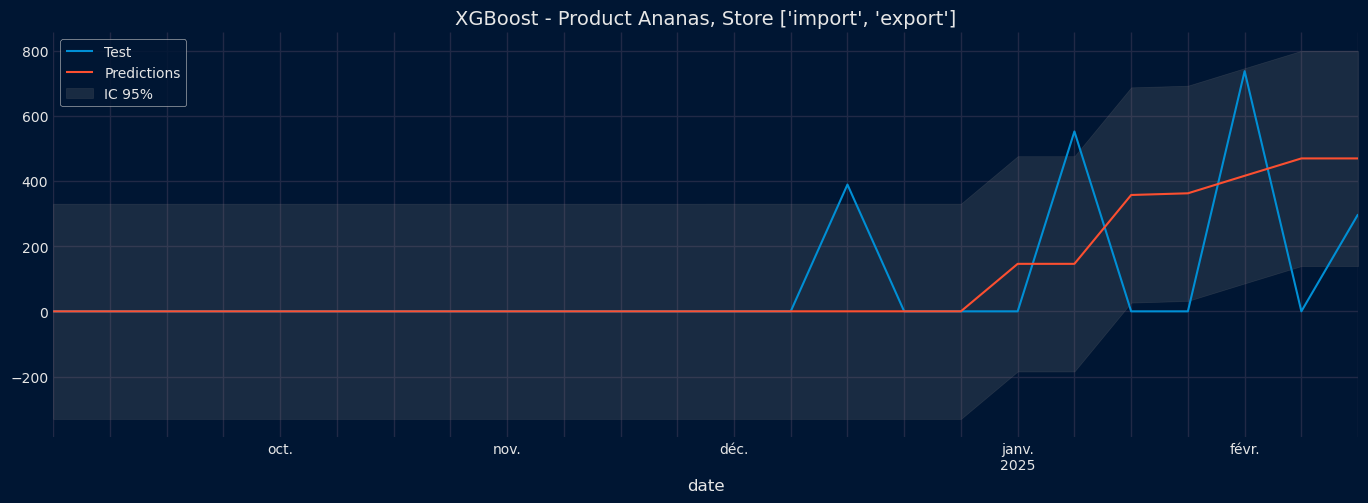

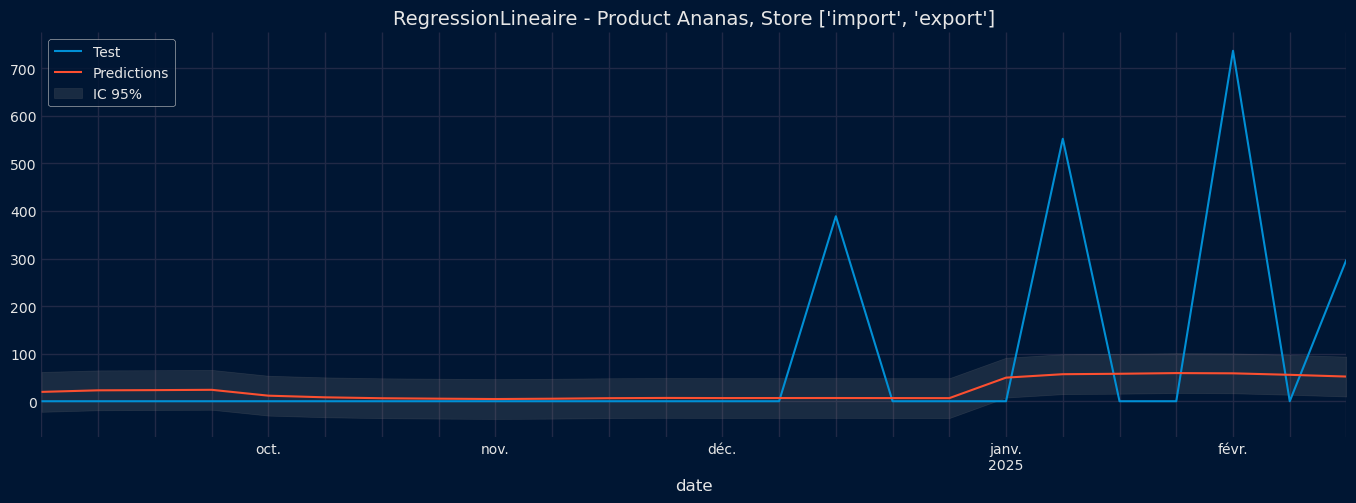

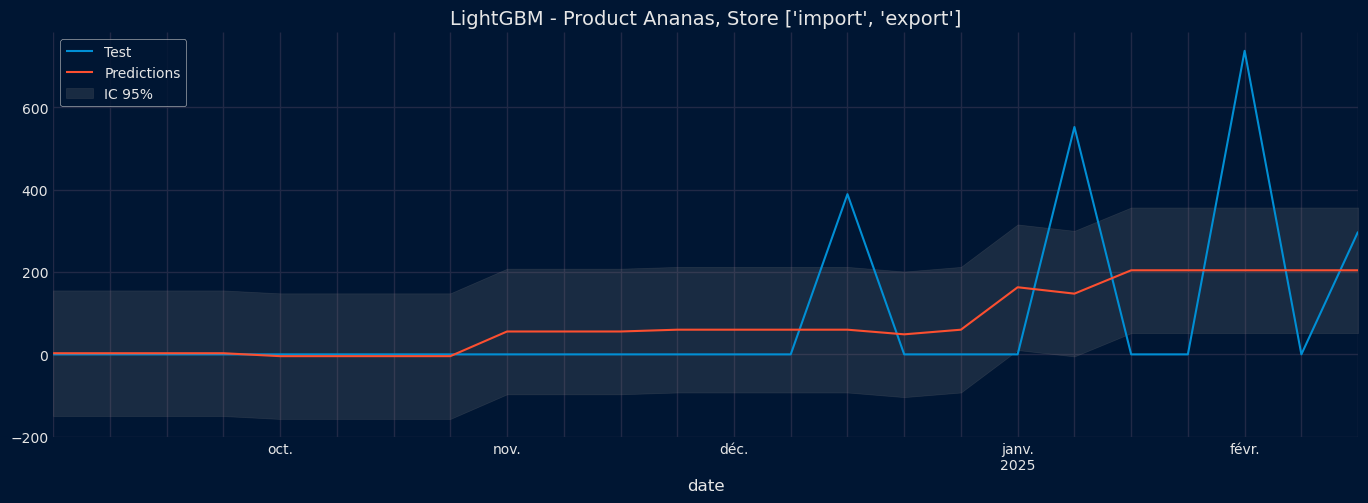

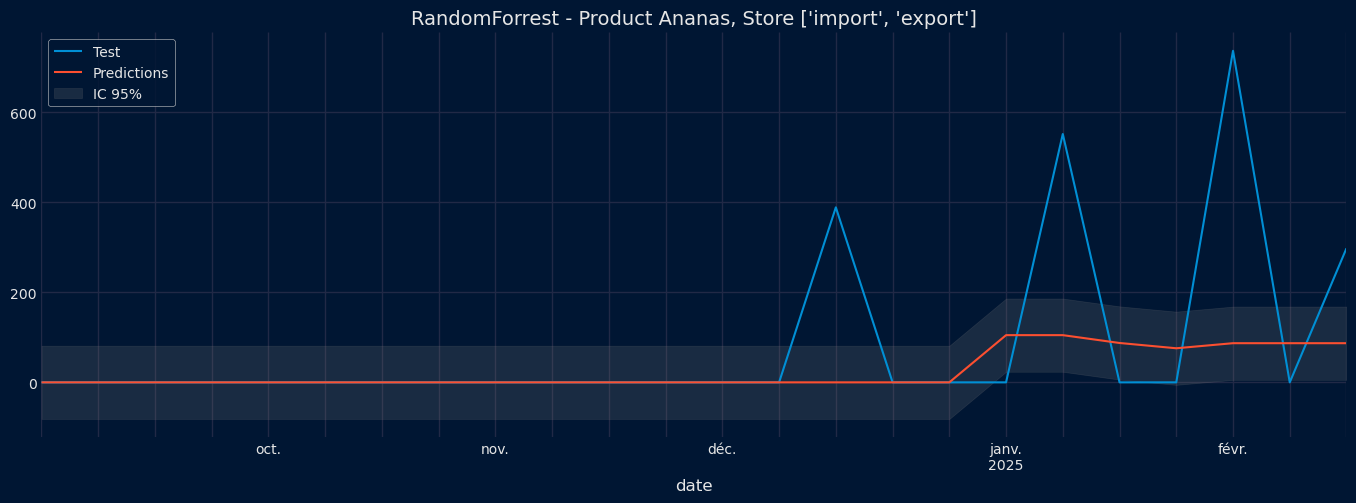

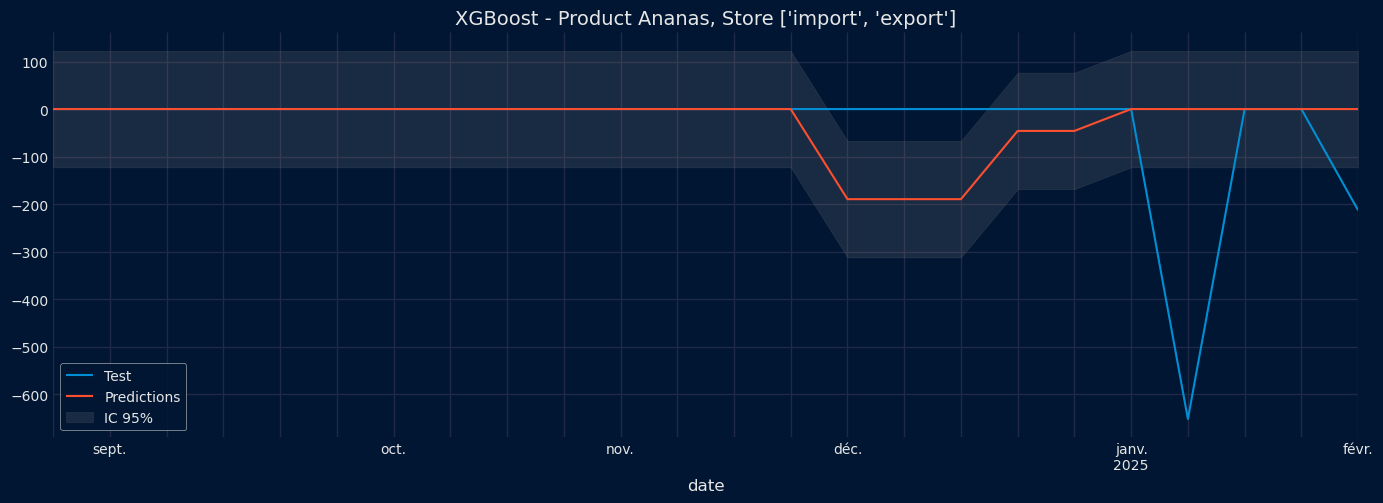

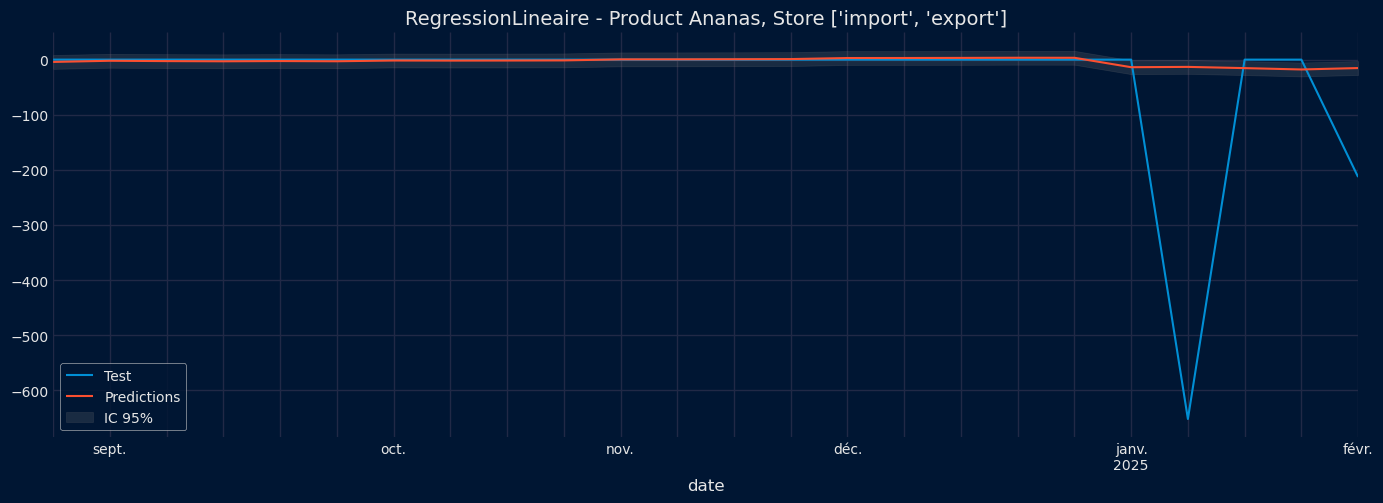

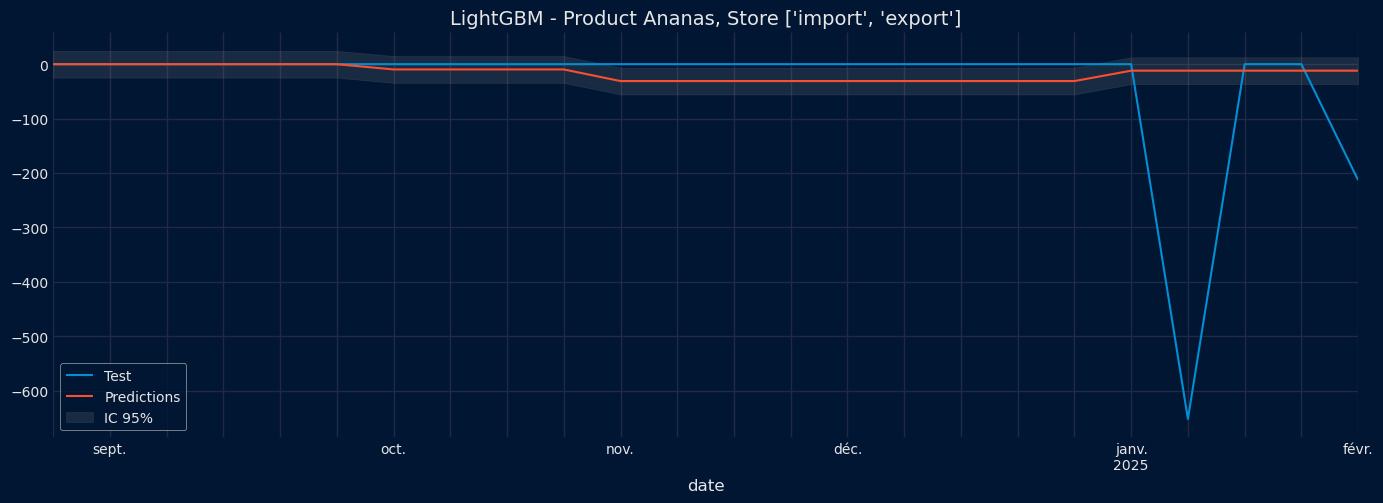

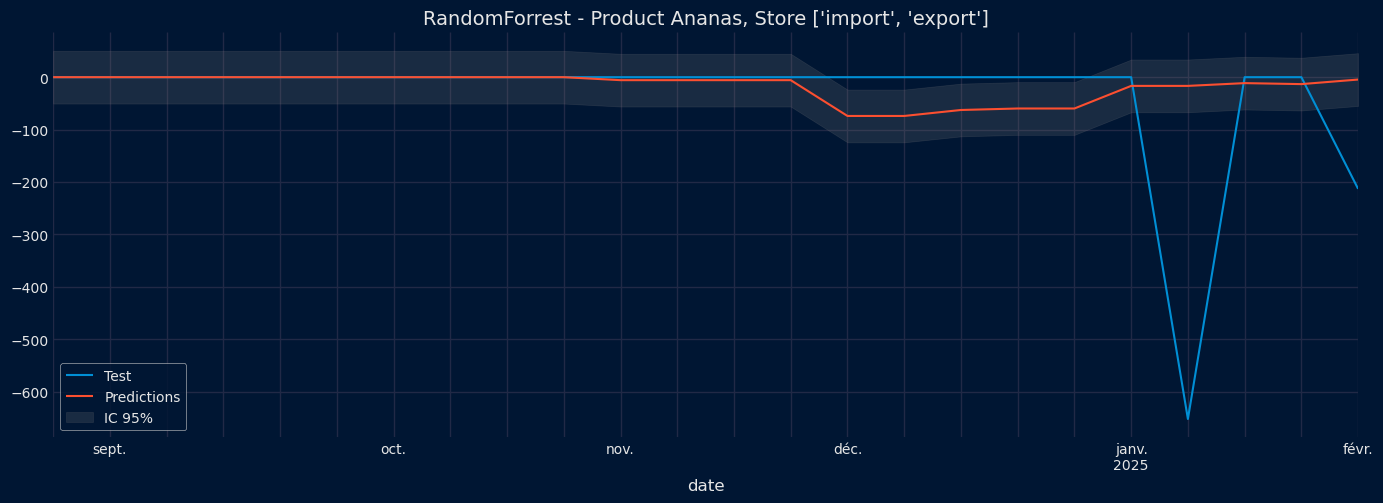

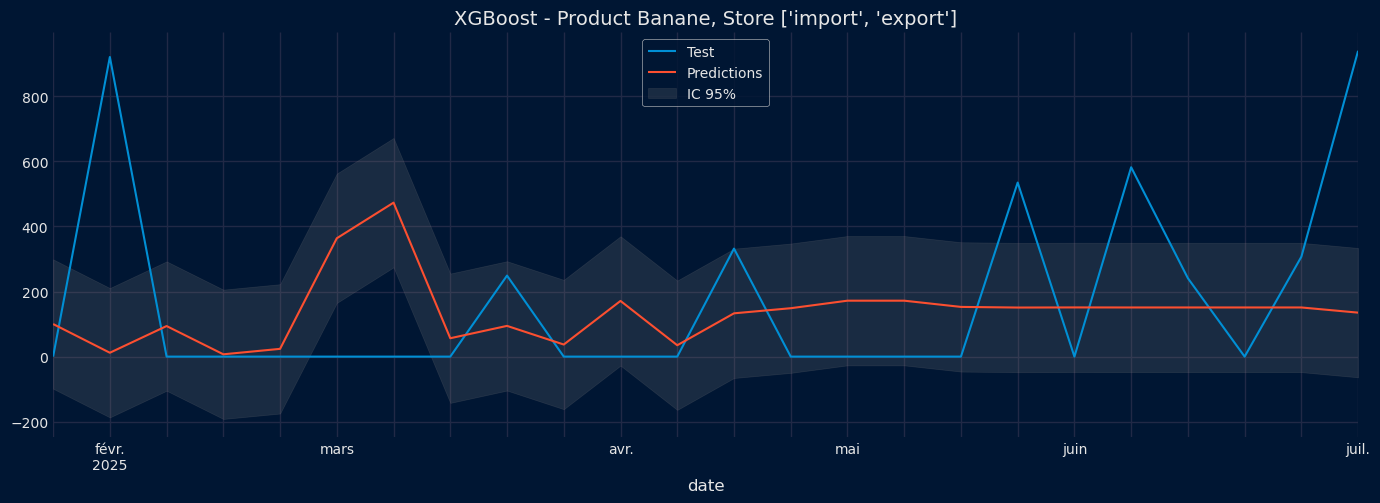

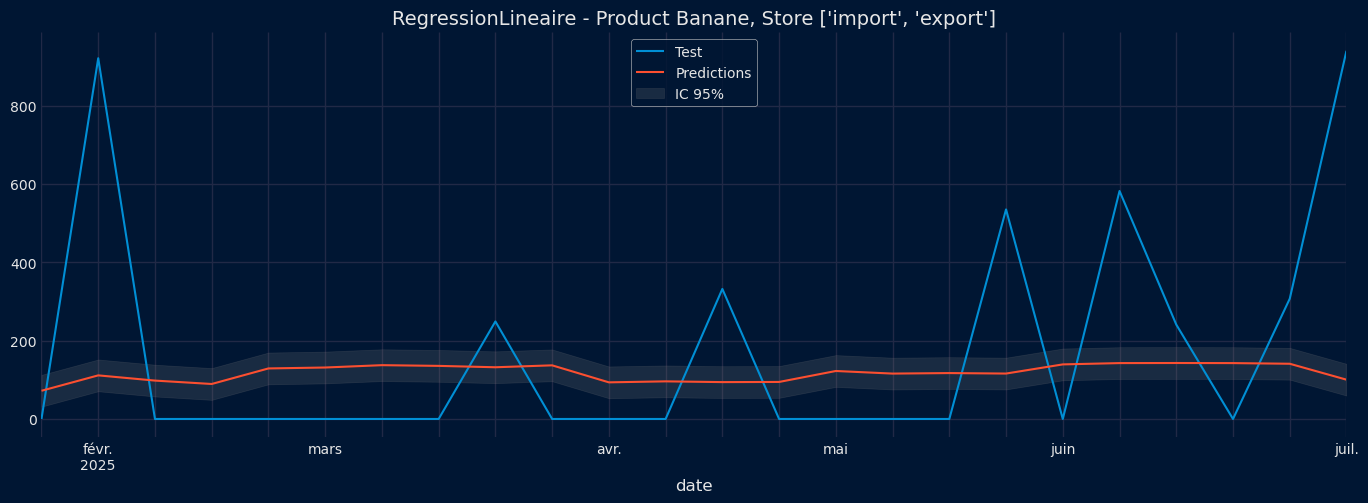

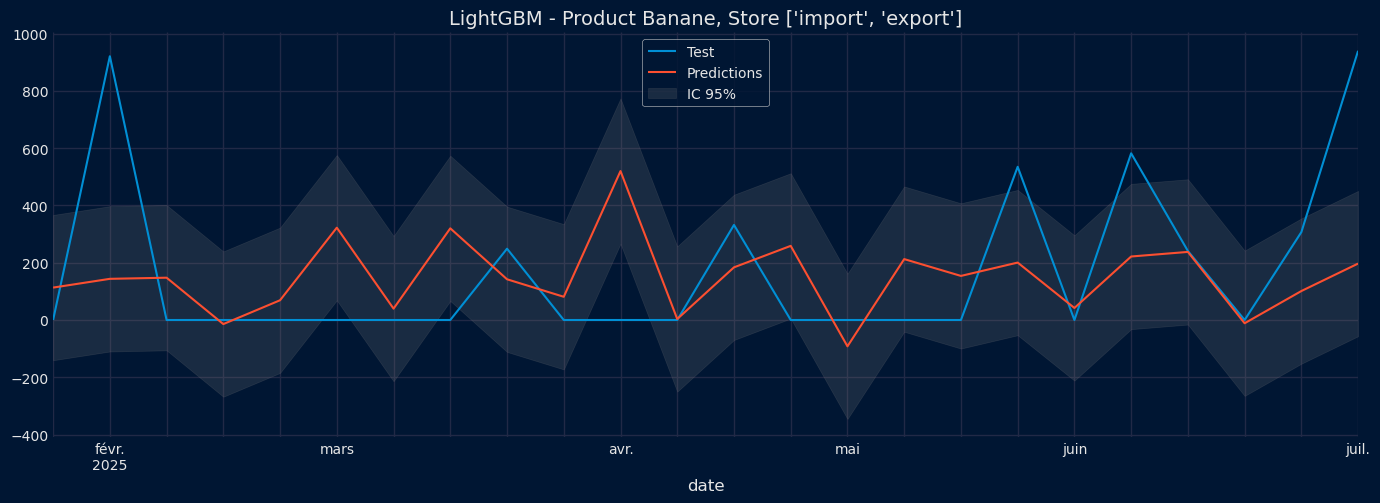

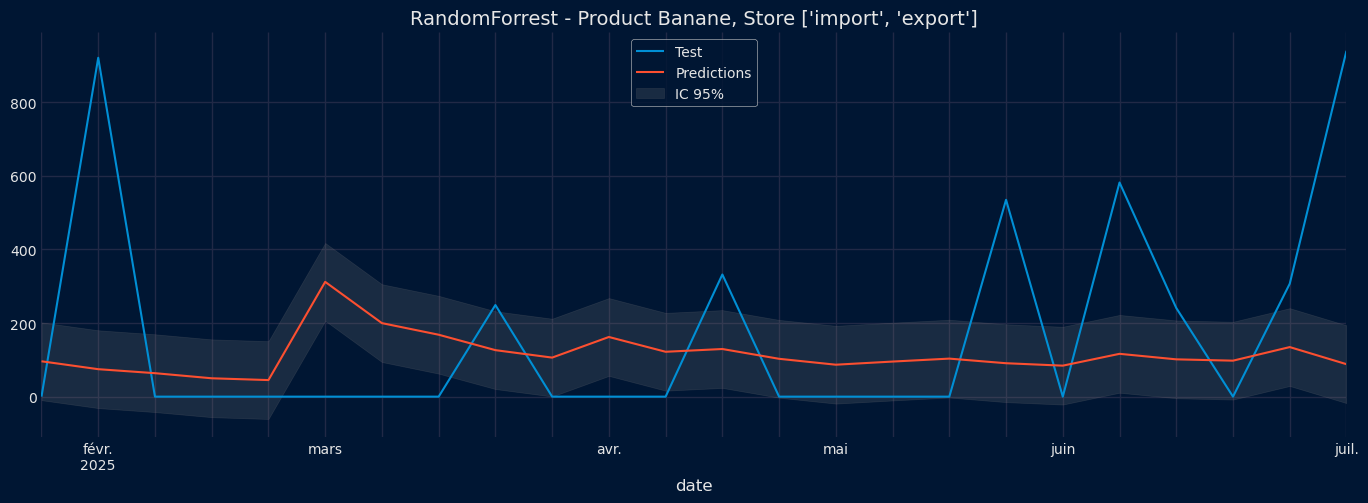

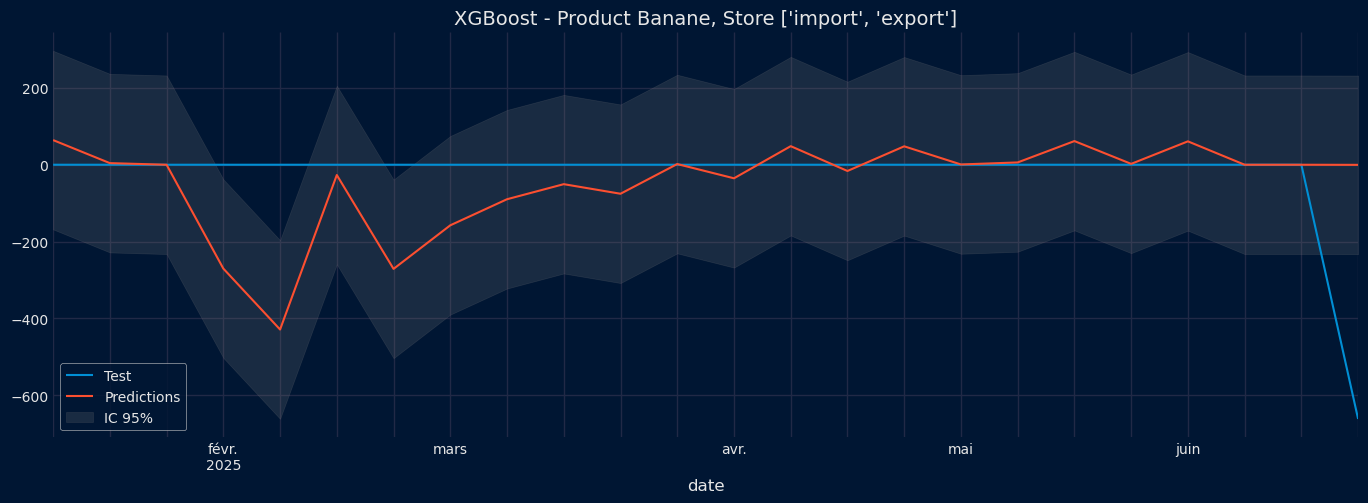

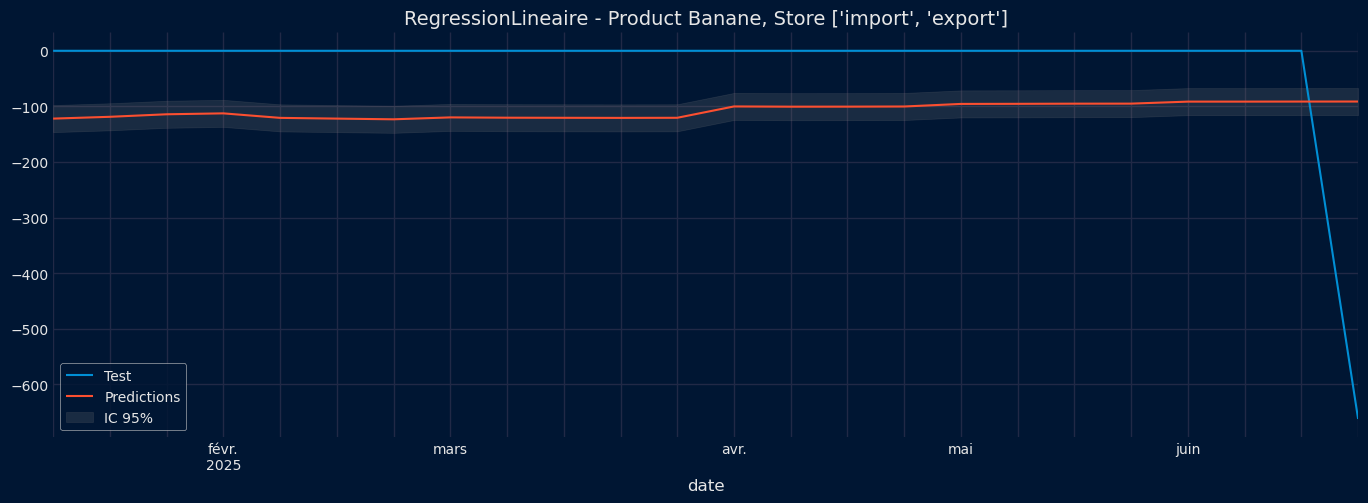

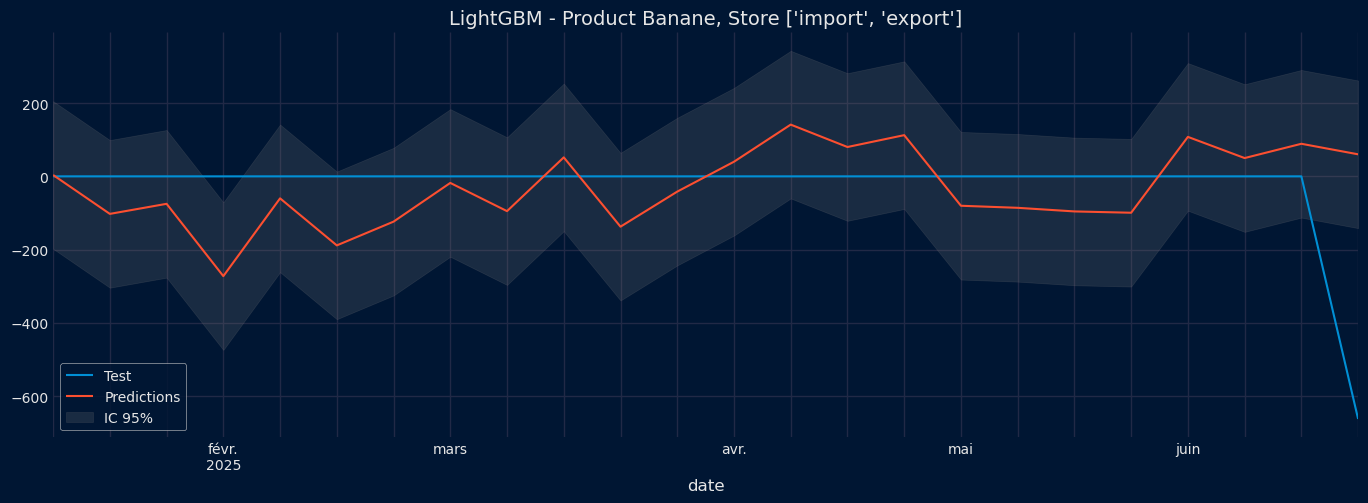

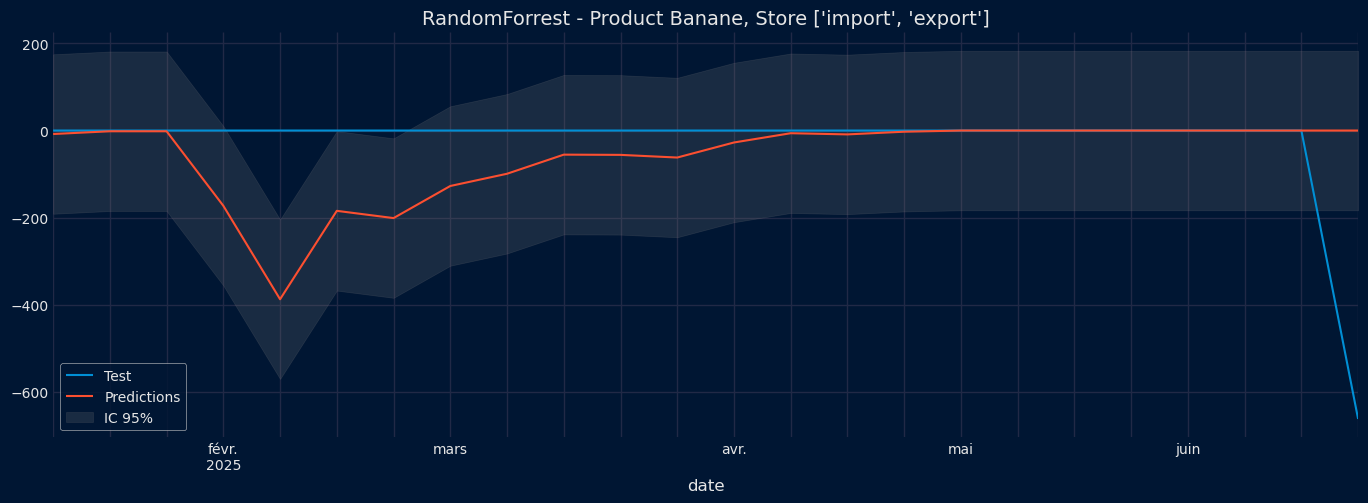

In [118]:
for index,product in enumerate(products):
    print(f"Product {index}/{len(products)}")
    for mouvement in type_mouvement:
        df = data[(data["product_name"] == product) & (data["type_movement"] == mouvement)]
        if df.shape[0]>WINDOW_SIZE:
            print(f"1 : {df.shape}")
            df = df.resample("W").sum().drop(columns=["product_name", "type_movement"])
            print(f"2 : {df.shape}")
            df['year'] = df.index.year
            df['month'] = df.index.month
            df['quarter'] = df.index.quarter
            df = df[["quantity", "year", "month", "quarter"]]
            print(f"3 : {df.shape}")
            train_set = df[:-TEST_SIZE]
            test_set = df[-TEST_SIZE:]
            print(train_set)
            for model_name, model in models.items():
                forecaster = ForecasterRecursive(
                    regressor=model,
                    # steps=TEST_SIZE,
                    lags=LAG_SIZE,
                    window_features=RollingFeatures(stats=['mean'], window_sizes=WINDOW_SIZE),
                    transformer_y=StandardScaler(),
                    transformer_exog=StandardScaler()
                )
                
                forecaster.fit(
                    y=train_set["quantity"],
                    exog=train_set[["year", "month", "quarter"]],
                )

                predictions = forecaster.predict(
                    exog=test_set[["year", "month", "quarter"]],
                    steps=TEST_SIZE)

                prediction_std = np.std(predictions)
                lower_bound = predictions - 1.96 * prediction_std
                upper_bound = predictions + 1.96 * prediction_std

                # set_dark_theme()
                # fig, ax = plt.subplots(figsize=(15, 5))

                # test_set["quantity"].plot(ax=ax, label='Test')
                # predictions.plot(ax=ax, label='Predictions')
                # ax.fill_between(predictions.index, lower_bound, upper_bound, color='gray', alpha=0.2, label='IC 95%')
                # ax.set_title(f"{model_name} - Product {product}, Store {type_mouvement}", fontsize=14)
                # ax.legend()

                # plt.savefig(f"Forecast_{model_name}_Product-{product}_Store-{store}.png", dpi=300)
                # plt.close()

                # Calculer les métriques
                rmse = np.round(np.sqrt(mean_squared_error(test_set["quantity"], np.round(predictions))), 0)
                mae = np.round(mean_absolute_error(test_set["quantity"], np.round(predictions)), 0)
                mape = mean_absolute_percentage_error(test_set["quantity"], np.round(predictions))
                
                # Stocker les métriques dans la variable performance
                performance[model_name]["rmse"].append(rmse)
                performance[model_name]["mae"].append(mae)
                performance[model_name]["mape"].append(mape)


In [107]:
performance

{'XGBoost': {'rmse': [199.0, 156.0, 320.0, 186.0],
  'mae': [109.0, 64.0, 227.0, 99.0],
  'mape': [2.5032507928801008e+17,
   1.2422428972163618e+17,
   4.3328381414993645e+17,
   3.229456232793593e+17]},
 'RegressionLineaire': {'rmse': [196.0, 137.0, 293.0, 158.0],
  'mae': [92.0, 39.0, 207.0, 128.0],
  'mape': [7.412174386713941e+16,
   1.688849860263936e+16,
   3.475277712454233e+17,
   4.6706081135521517e+17]},
 'LightGBM': {'rmse': [176.0, 138.0, 299.0, 182.0],
  'mae': [109.0, 50.0, 212.0, 120.0],
  'mape': [2.3643898043695104e+17,
   6.6615744488188584e+16,
   4.505476127215234e+17,
   4.034474666186069e+17]},
 'RandomForrest': {'rmse': [188.0, 140.0, 306.0, 174.0],
  'mae': [86.0, 52.0, 214.0, 86.0],
  'mape': [6.680339447266236e+16,
   7.430939385161318e+16,
   3.555967205777954e+17,
   2.628976282477527e+17]}}

In [108]:
# Créer un DataFrame pour les métriques moyennes
metrics_df = pd.DataFrame({
    "Model": list(performance.keys()),
    "RMSE_Mean": [np.mean(performance[model]["rmse"]) for model in performance],
    "MAE_Mean": [np.mean(performance[model]["mae"]) for model in performance],
    "MAPE_Mean (en %)": [np.mean(performance[model]["mape"])*100 for model in performance]
})
# On affiche les resultats moyenne des erreurs
print(metrics_df)

# Calculer un score global basé sur une combinaison pondérée des métriques
metrics_df["Score"] = (
    0.5 * metrics_df["RMSE_Mean"] +
    0.3 * metrics_df["MAE_Mean"] +
    0.2 * metrics_df["MAPE_Mean (en %)"]
)

# Identifier le meilleur modèle basé sur le score global
best_model_name = metrics_df.loc[metrics_df["Score"].idxmin(), "Model"]
print("\nMeilleur modèle global basé sur le score pondéré :", best_model_name)

# Charger le modèle sélectionné pour les prédictions futures
best_model = models[best_model_name]

                Model  RMSE_Mean  MAE_Mean  MAPE_Mean (en %)
0             XGBoost     215.25    124.75      2.826947e+19
1  RegressionLineaire     196.00    116.50      2.263997e+19
2            LightGBM     198.75    122.75      2.892625e+19
3       RandomForrest     202.00    109.50      1.899018e+19

Meilleur modèle global basé sur le score pondéré : RandomForrest


In [17]:
# Liste des modèles à comparer
models = {
    'XGBoost': {
        "alg": xgb.XGBRegressor(objective='reg:squarederror'),
        "params_grid_search": {
            "eta": [0.1, 0.2, 0.3, 0.4],
            "n_estimators": [50, 100, 200]
        }
    },
    "RegressionLineaire": {
        "alg": LinearRegression(),
        "params_grid_search": {}  # Aucun paramètre spécifique pour LinearRegression
    },
    'Ridge': {
        "alg": Ridge(alpha=1.0),
        "params_grid_search": {
            "alpha": [0.1, 0.5, 1.0, 5.0]
        }
    },
    'LightGBM': {
        "alg": LGBMRegressor(n_estimators=100, learning_rate=0.2, verbosity=-1),
        "params_grid_search": {
            "learning_rate": [0.1, 0.2, 0.3],
            "n_estimators": [50, 100, 200]
        }
    },
    'RandomForrest': {
        "alg": RandomForestRegressor(random_state=42, criterion="absolute_error"),
        "params_grid_search": {
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 10, 20, 30]
        }
    }
}

In [18]:
try:
    models["RegressionLineaire"]["params_grid_search"] 
except:
    

SyntaxError: incomplete input (2949705076.py, line 3)

In [22]:
from sklearn.linear_model import LinearRegression
import numpy as np

X = np.array([[1, 2], [2, 3], [3, 4], [4, 5]])  # features
y = np.array([
    [10, 15],   # sortie 1, sortie 2
    [20, 25],
    [30, 35],
    [40, 45]
])

model = LinearRegression()
model.fit(X, y)

print(model.predict([[5, 6],[1,2]]))  # Prédit les 2 sorties simultanément


[[50. 55.]
 [10. 15.]]
